In [30]:
import wandb
import pandas as pd
import os
from tqdm import tqdm

from table_plotter import print_result_table

In [31]:
api = wandb.Api(timeout=600)


In [32]:
# get all runs for a project
runs = api.runs("inchangbaek4907/pcgrl-llm")
len(runs)

195

In [33]:
import re

# Specify cache directory
cache_dir = "./wandb_cache"
os.makedirs(cache_dir, exist_ok=True)

dfs = []
skipped_runs = []  # List to store IDs of skipped runs

for run in tqdm(runs):
    # Skip the run if it's not finished
    if run.state != "finished":
        print(f"Skipping run {run.id} (state: {run.state})")
        skipped_runs.append(run.id)
        continue

    
    run_ids = list(run.historyKeys['keys'].keys())
    # filter starts with 'Iteration_'
    pattern = r'^Iteration_\d+/train'
    # 필터링
    iteration_ids = list(filter(lambda x: re.match(pattern, x), run_ids))
    exclude_keywords = ['ep_return', 'code', 'config', 'fps', 'video', 'image', 'ep_length']
    iteration_ids = list(filter(lambda x: not any(keyword in x for keyword in exclude_keywords), iteration_ids))
        
    
    # Define cache filename based on run ID
    cache_file = os.path.join(cache_dir, f"{run.id}.csv")
    
    # Check if cached file exists
    if os.path.exists(cache_file) and False:
        # Load cached DataFrame
        df = pd.read_csv(cache_file)
    else:
        try:
        
            data_frames = []
            # Iterate over iteration_ids to fetch data for each key
            for key in iteration_ids:
                # Fetch history for the current key and "train/step"
                df = run.history(keys=[key, "train/step"])
                
                # Add a column to identify the current iteration
                df = df.melt(id_vars=['train/step'], value_vars=[key], var_name='key', value_name='value')
                df['train/iteration'] = df['key'].apply(lambda x: int(re.search(r'\d+', x).group()))

                # Append the fetched data to the list
                data_frames.append(df)
            
            # Combine all DataFrames into a single DataFrame
            df_origin = pd.concat(data_frames, axis=0).reset_index(drop=True)
            
            # Process the combined DataFrame
            df = df_origin.copy()
    
            for key, value in run.config.items():
                if isinstance(value, list):
                    value = ",".join(map(str, value))  # Convert list to comma-separated string
                df[key] = value

            # Get the column names starts with 'train/'

            auxiliary_key_filter = ['train/iteration', 'train/step', 'key', 'value']
            # Filter columns
            key_filter = ['target_character', 'pe', 'branch_factor', 'exp_name', 'evaluator', 'total_iterations',
                          'reward_feature', 'fewshot', 'problem', 'seed'] + auxiliary_key_filter
            
            df = df[key_filter]
            # Save DataFrame to cache as CSV
            # df.to_csv(cache_file, index=False)
        except KeyError as e:
            print(df_origin.columns)
            print(run_ids)
            print(f"Skipping run {run.id} due to KeyError: {e}")      
    
    # Append DataFrame to list
    dfs.append(df)
    

# accum train/step with iteration
df['train/step/accum'] = max(df['train/step']) * df['train/iteration'] + df['train/step']

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)
df.head()  # Display the first few rows for inspection

# Print summary of skipped runs
print("\nSummary of Skipped Runs:")
print(f"Total skipped runs: {len(skipped_runs)}")
print("Skipped run IDs:", skipped_runs)

100%|██████████| 195/195 [09:42<00:00,  2.99s/it]


Summary of Skipped Runs:
Total skipped runs: 0
Skipped run IDs: []


In [46]:
df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,train/iteration,train/step,key,value,train/step/accum
0,N,io,2,def,vit,1,array,False,binary,1,1,1536000.0,train/similarity,0.035179,NaN
1,N,io,2,def,vit,1,array,False,binary,1,1,3072000.0,train/similarity,0.037583,NaN
2,N,io,2,def,vit,1,array,False,binary,1,1,4608000.0,train/similarity,0.032226,NaN
3,N,io,2,def,vit,1,array,False,binary,1,1,6144000.0,train/similarity,0.029805,NaN
4,N,io,2,def,vit,1,array,False,binary,1,1,7680000.0,train/similarity,0.030028,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36059,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,43008000.0,train/similarity,0.131263,436224000.0
36060,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,44544000.0,train/similarity,0.152995,437760000.0
36061,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,46080000.0,train/similarity,0.167360,439296000.0
36062,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,47616000.0,train/similarity,0.171276,440832000.0


In [52]:
df['key'] = df['key'].str.replace(r'^Iteration_\d+/', '', regex=True)
df['train/step/accum'] = max(df['train/step']) * (df['train/iteration'] - 1) + df['train/step']
df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,train/iteration,train/step,key,value,train/step/accum
0,N,io,2,def,vit,1,array,False,binary,1,1,1536000.0,train/similarity,0.035179,1536000.0
1,N,io,2,def,vit,1,array,False,binary,1,1,3072000.0,train/similarity,0.037583,3072000.0
2,N,io,2,def,vit,1,array,False,binary,1,1,4608000.0,train/similarity,0.032226,4608000.0
3,N,io,2,def,vit,1,array,False,binary,1,1,6144000.0,train/similarity,0.029805,6144000.0
4,N,io,2,def,vit,1,array,False,binary,1,1,7680000.0,train/similarity,0.030028,7680000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36059,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,43008000.0,train/similarity,0.131263,387072000.0
36060,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,44544000.0,train/similarity,0.152995,388608000.0
36061,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,46080000.0,train/similarity,0.167360,390144000.0
36062,M,got-longiter,2,longiter,vit,9,array,False,binary,0,8,47616000.0,train/similarity,0.171276,391680000.0


In [53]:
time_str = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")

In [54]:
df.to_csv(f"wandb_output_{time_str}_graph.csv", index=False)

In [67]:

df['seed'] = df['seed'] % 3
df

,target_character,pe,branch_factor,exp_name,evaluator,total_iterations,reward_feature,fewshot,problem,seed,train/iteration,train/step,key,value,train/step/accum
0,N,io,2,def,vit,1,array,False,binary,1,1,1536000.0,train/similarity,0.035179,1536000.0
1,N,io,2,def,vit,1,array,False,binary,1,1,3072000.0,train/similarity,0.037583,3072000.0
2,N,io,2,def,vit,1,array,False,binary,1,1,4608000.0,train/similarity,0.032226,4608000.0
3,N,io,2,def,vit,1,array,False,binary,1,1,6144000.0,train/similarity,0.029805,6144000.0
4,N,io,2,def,vit,1,array,False,binary,1,1,7680000.0,train/similarity,0.030028,7680000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36059,M,got-longiter-longiter,2,longiter,vit,9,array,False,binary,0,8,43008000.0,train/similarity,0.131263,387072000.0
36060,M,got-longiter-longiter,2,longiter,vit,9,array,False,binary,0,8,44544000.0,train/similarity,0.152995,388608000.0
36061,M,got-longiter-longiter,2,longiter,vit,9,array,False,binary,0,8,46080000.0,train/similarity,0.167360,390144000.0
36062,M,got-longiter-longiter,2,longiter,vit,9,array,False,binary,0,8,47616000.0,train/similarity,0.171276,391680000.0


In [70]:
# get the colums in the dataframe and get all columns without key and value
columns = df.columns
columns = columns[~columns.isin(['key', 'value'])]


pivoted_df = df.pivot(index=columns, columns='key', values='value')
pivoted_df

Index(['target_character', 'pe', 'branch_factor', 'exp_name', 'evaluator',
       'total_iterations', 'reward_feature', 'fewshot', 'problem', 'seed',
       'train/iteration', 'train/step', 'train/step/accum'],
      dtype='object')


ValueError: Index contains duplicate entries, cannot reshape

<Axes: xlabel='train/step/accum', ylabel='value'>

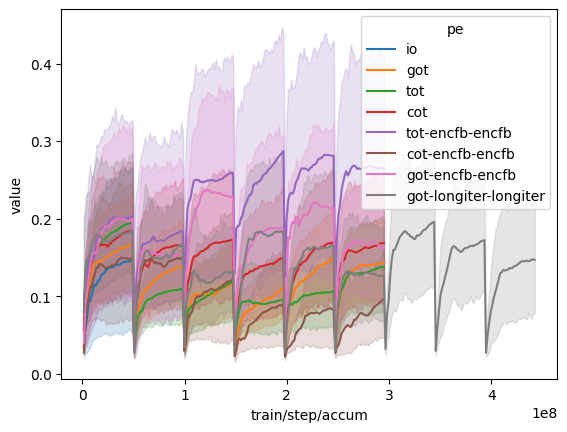

In [72]:
import seaborn as sns
sns.lineplot(data=df, x='train/step/accum', y='value', hue='pe')

In [56]:
# remove pe == cotsc
df = df[df['pe'] != 'cotsc']

# if the exname is not def make the pe to 'pe+exp_name'
df['pe'] = df.apply(lambda x: x['pe'] + '-' +  x['exp_name'] if x['exp_name'] != 'def' else x['pe'], axis=1)

In [39]:
df.groupby(['pe', 'evaluator', 'fewshot', 'seed']).count()

target_character  branch_factor  \
pe           evaluator fewshot seed                                    
cot          vit       False   0                  768            768   
                               1                 1152           1152   
                               2                  960            960   
                       True    0                  960            960   
                               1                  960            960   
                               2                  960            960   
cot-encfb    vit       False   0                  960            960   
                               1                  960            960   
                               2                  928            928   
got          llm       False   0                  960            960   
                               1                  960            960   
                               2                  960            960   
             vit       False   0                  960            960   
                               1                  960            960   
                               2                  800            800   
                       True    0                  960            960   
                               1                  960            960   
                               2                  960            960   
got-encfb    vit       False   0                  896            896   
                               1                  800            800   
                               2                  960            960   
got-longiter vit       False   0                 1440           1440   
                               1                 1440           1440   
                               2                 1440           1440   
io           vit       False   0                  160            160   
                               1                  160            160   
                               2                  160            160   
tot          llm       False   0                  960            960   
                               1                  960            960   
                               2                  960            960   
             vit       False   0                  960            960   
                               1                  960            960   
                               2                  960            960   
                       True    0                  960            960   
                               1                  960            960   
                               2                  960            960   
tot-encfb    vit       False   0                  960            960   
                               1                  960            960   
                               2                  960            960   

                                     exp_name  total_iterations  \
pe           evaluator fewshot seed                               
cot          vit       False   0          768               768   
                               1         1152              1152   
                               2          960               960   
                       True    0          960               960   
                               1          960               960   
                               2          960               960   
cot-encfb    vit       False   0          960               960   
                               1          960               960   
                               2          928               928   
got          llm       False   0          960               960   
                               1          960               960   
                               2          960               960   
             vit       False   0          960               960   
                               1          960               960   
            